Opening HLS stream…
✅  First frame saved to /Users/ace/Documents/GitHub/tt2check/tt2_snapshot.jpg


Text(0.5, 1.0, 'Top Thrill 2 – front-tower camera (first live frame)')

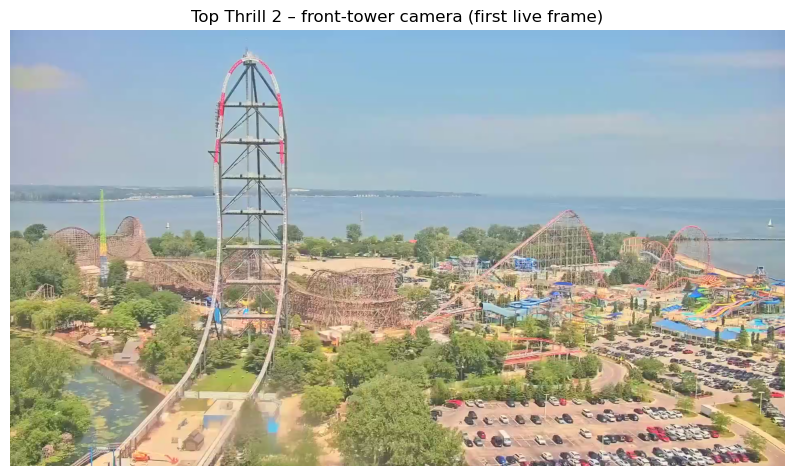

In [3]:
import cv2, time, pathlib, matplotlib.pyplot as plt

# --- stream & output ---
M3U8     = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"
SNAPFILE = pathlib.Path("tt2_snapshot.jpg")
TIMEOUT  = 15           # seconds to keep trying

print("Opening HLS stream…")
cap  = cv2.VideoCapture(M3U8, cv2.CAP_FFMPEG) 
start = time.time()

while True:
    ok, frame = cap.read()
    if ok:
        SNAPFILE.write_bytes(cv2.imencode(".jpg", frame)[1])
        print("✅  First frame saved to", SNAPFILE.resolve())
        break
    if time.time() - start > TIMEOUT:
        cap.release()
        raise RuntimeError(f"No frame within {TIMEOUT}s; "
                           "check URL, network, or OpenCV-FFmpeg build.")
    time.sleep(0.25)      # small back-off loop

cap.release()

# --- display the frame so you can click & measure ROIs ---
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Top Thrill 2 – front-tower camera (first live frame)")


In [2]:
import cv2, matplotlib.pyplot as plt
%matplotlib tk

IMG = "tt2_snapshot.jpg"      # path to your saved frame

# --- load & display ---
img = cv2.imread("tt2_snapshot.jpg")
plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Click BL & TR for BOT, MID, TOP; press Enter when done")
coords = plt.ginput(6)
plt.close()

# --- convert to x, y, w, h ---
rois = []
for i in range(0, 6, 2):
    (x0, y0), (x1, y1) = coords[i], coords[i+1]
    x, y   = int(min(x0, x1)), int(min(y0, y1))
    w, h   = int(abs(x1 - x0)), int(abs(y1 - y0))
    rois.append((x, y, w, h))

print(f"ROI_BOT = {rois[0]}\nROI_MID = {rois[1]}\nROI_TOP = {rois[2]}")


ROI_BOT = (600, 761, 70, 99)
ROI_MID = (503, 445, 30, 82)
ROI_TOP = (581, 887, 30, 18)


In [13]:
import cv2, streamlink, itertools, re, time

M3U8_PAGE = "https://pixelcaster.com/live/cedarpoint/https/cam2.html"

HOSTS = [
    "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "https://cs3.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "https://cs2.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "http://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "http://cs3.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "http://cs2.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
]

def open_stream():
    """Try known hosts, then let Streamlink resolve the current one."""
    for url in HOSTS:
        cap = cv2.VideoCapture(url, cv2.CAP_FFMPEG)
        if cap.isOpened():
            print(f"[stream] connected → {url}")
            return cap
        cap.release()

    # — Streamlink fallback —
    try:
        hls = streamlink.streams(M3U8_PAGE)["best"].url
        cap  = cv2.VideoCapture(hls, cv2.CAP_FFMPEG)
        if cap.isOpened():
            print(f"[stream] resolved via Streamlink → {hls}")
            return cap
        cap.release()
    except Exception as e:
        print("[stream] Streamlink failed:", e)

    raise RuntimeError("All host attempts and Streamlink resolution failed")


In [5]:
import cv2, time, enum
from collections import deque

# ───────── stream & ROIs ─────────
# This script will try to connect to one of the following URLs directly.
HOSTS = [
    "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "https://cs3.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "https://cs2.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "http://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "http://cs3.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
    "http://cs2.pixelcaster.com/live/cedar2.stream/playlist.m3u8",
]

ROI_BOT = (608, 761, 55, 97)
ROI_MID = (674, 234, 8, 189)
ROI_TOP = (505, 429, 22, 109)

# --- THE NEW, SUPERIOR FUNCTION ---
def open_stream_with_streamlink():
    """Use Streamlink to resolve the HLS playlist to a direct stream URL."""
    for url in HOSTS:
        try:
            # Use streamlink to find available streams
            streams = streamlink.streams(url)
            if not streams:
                print(f"[streamlink] No streams found at {url}, trying next...")
                continue
            
            # Get the direct URL of the best quality stream
            stream_url = streams["best"].url
            print(f"[streamlink] Found stream URL: {stream_url}")
            
            # Now, open this stable URL with OpenCV
            cap = cv2.VideoCapture(stream_url, cv2.CAP_FFMPEG)
            if cap.isOpened():
                print(f"[stream] Successfully connected via streamlink to → {url}")
                return cap
            cap.release()

        except Exception as e:
            print(f"[streamlink] Failed to connect to {url}: {e}")
            continue

    raise RuntimeError("All Streamlink connection attempts failed.")

# --- Replace your old open_stream() call with the new one ---
cap = open_stream_with_streamlink()

# ───────── finite states ─────────
class S(enum.Enum):
    IDLE=0; ASC1=1; RBACK=2; WAIT=3; ASC3=4
state = S.IDLE

# history for velocity smoothing
hist = deque(maxlen=3)         # store last 3 cy
bg_bot, bg_top = None, None    # adaptive backgrounds for ROIs
t0   = None                    # WAIT start time

# thresholds
MOTION_ENTER = 330          # blob enters ROI_BOT
MOTION_EXIT  = 330          # blob small enough → RBACK done
TOP_ENTER    = 330         # pixels of motion inside ROI_TOP ⇒ SUCCESS
UP,  DOWN    = -0.4, 0.4     # velocity thresholds (px/frame)
WAIT_TIMEOUT = 30       

# colour helper for console prints
C = {S.IDLE:"\033[37m",S.ASC1:"\033[32m",S.RBACK:"\033[33m",
     S.WAIT:"\033[36m",S.ASC3:"\033[35m", "END":"\033[0m"}

def centroid_from_mask(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    c = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(c) < 40:  # ignore tiny blobs
        return None
    M = cv2.moments(c)
    return (int(M["m01"]/M["m00"])) if M["m00"] else None

while True:
    ok, frame = cap.read()
    if not ok:
        print("\n[stream] lost connection – reconnecting…")
        time.sleep(1)
        cap.release()
        cap = open_stream()
        # Reset backgrounds on reconnect
        bg_bot, bg_top = None, None
        continue

    # ---------- ROI Processing ----------
    xb,yb,wb,hb = ROI_BOT
    bot = frame[yb:yb+hb, xb:xb+wb]
    xt,yt,wt,ht = ROI_TOP
    top = frame[yt:yt+ht, xt:xt+wt]

    # bg init & update
    if bg_bot is None:
        bg_bot = bot.astype("float32")
        bg_top = top.astype("float32")
        continue

    # ROI_BOT (bottom) processing for centroid and velocity
    diff_bot   = cv2.absdiff(bot, bg_bot.astype("uint8"))
    motion_bot = (diff_bot > 25).sum()
    cv2.accumulateWeighted(bot.astype("float32"), bg_bot, 0.001)

    gray = cv2.cvtColor(diff_bot, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)
    cy_local = centroid_from_mask(mask)           # 0..h-1 or None
    cy = yb + cy_local if cy_local is not None else None

    # ROI_TOP processing for success detection
    diff_top   = cv2.absdiff(top, bg_top.astype("uint8"))
    motion_top = (diff_top > 25).sum()
    cv2.accumulateWeighted(top.astype("float32"), bg_top, 0.001)

    # velocity (smoothed)
    hist.append(cy_local if cy_local is not None else hist[-1] if hist else None)
    if len(hist) >= 3 and None not in hist:
        v = (hist[-1] - hist[0]) / 2.0            # avg over 2 frames
    else:
        v = 0

    # ---------- console debug ----------
    print(f"\r{C[state]}{state.name:<5}{C['END']} "
          f"bot={motion_bot:<4} top={motion_top:<4} v={v:+5.1f} cy={cy}", end="")

    # ---------- FSM ----------
    if state==S.IDLE and motion_bot > MOTION_ENTER and v < UP:
        state=S.ASC1

    elif state==S.ASC1 and v > DOWN and cy_local is not None:
        state=S.RBACK

    elif state==S.RBACK and (motion_bot < MOTION_EXIT or cy_local is None):
        state, t0 = S.WAIT, time.time()

    elif state==S.WAIT:
        # pause the timeout clock while train blob is still present
        if motion_bot > MOTION_EXIT:
            t0 = time.time()
        elif motion_bot > MOTION_ENTER and v < UP:
            state=S.ASC3
        elif time.time()-t0 > WAIT_TIMEOUT:
            print("\nINCOMPLETE"); state=S.IDLE

    elif state==S.ASC3:
        # SUCCESS: is detected if the train appears in the ROI at the top.
        if motion_top > TOP_ENTER:
            print("\nSUCCESS"); state=S.IDLE

        # ROLLBACK: If success hasn't happened, and the train is seen in
        # the bottom ROI moving downwards, it's a rollback.
        elif v > DOWN and cy is not None:
            print("\nROLLBACK"); state=S.IDLE

    cv2.rectangle(frame, (xb,yb), (xb+wb,yb+hb), (0,255,0), 1)   # bottom
    cv2.rectangle(frame, (xt,yt), (xt+wt,yt+ht), (0,0,255), 1)   # crest
    cv2.imshow("debug (Esc to quit)", frame)
    if cv2.waitKey(1) & 0xFF == 27: break

[streamlink] Found stream URL: https://cs4.pixelcaster.com/live/cedar2.stream/chunks.m3u8?nimblesessionid=33255791
[stream] Successfully connected via streamlink to → https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8
IDLE  bot=374  top=49   v= +0.0 cy=None

KeyboardInterrupt: 

In [1]:
import cv2
import time
import enum
import streamlink
from collections import deque
import numpy as np

# ───────── Robust Stream Opener (Unchanged) ─────────
def open_stream(url):
    print(f"[stream] Attempting to connect to {url} via Streamlink...")
    try:
        streams = streamlink.streams(url)
        stream_url = streams["best"].url
        print(f"[stream] Streamlink success. Opening URL: {stream_url}")
        cap = cv2.VideoCapture(stream_url, cv2.CAP_FFMPEG)
        if cap.isOpened():
            print("[stream] Connection successful.")
            return cap
    except Exception as e:
        print(f"[stream] Failed to connect: {e}")
    return None

# ───────── Configuration ─────────
HOST_URL = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"
ROI_BOT = (608, 761, 55, 97)
ROI_TOP = (505, 429, 22, 109)

# ───────── Finite States & Logic ─────────
class S(enum.Enum):
    IDLE=0; ASC1=1; RBACK=2; WAIT=3; ASC3=4

state = S.IDLE
hist = deque(maxlen=3)
bg_bot, bg_top = None, None
t0 = None

# --- NEW: Clearer, Tuned Thresholds ---
# Because the background is now "pristine", the motion values will be much higher.
# These new thresholds are a good starting point.
ENTER_THRESH = 900  # Threshold to detect a new train entering.
EXIT_THRESH  = 800  # Threshold for the train leaving the ROI after rollback.
TOP_THRESH   = 800  # Threshold for detecting the train at the top.
UP,  DOWN    = -0.5, 0.5
WAIT_TIMEOUT = 30

C = {S.IDLE:"\033[37m",S.ASC1:"\033[32m",S.RBACK:"\033[33m",
     S.WAIT:"\033[36m",S.ASC3:"\033[35m", "END":"\033[0m"}

def centroid_from_mask(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts: return None
    c = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(c) < 40: return None
    M = cv2.moments(c)
    return (int(M["m01"]/M["m00"])) if M["m00"] else None

# ───────── Main Processing Loop ─────────
cap = None
while True:
    if cap is None or not cap.isOpened():
        cap = open_stream(HOST_URL)
        if cap is None:
            time.sleep(5); continue
        bg_bot, bg_top = None, None
        state = S.IDLE
        print("[main] Connection established. Starting tracking logic.")

    ok, frame = cap.read()
    if not ok:
        print("\n[main] Frame grab failed. Reconnecting..."); cap.release(); cap = None; continue

    xb,yb,wb,hb = ROI_BOT
    bot = frame[yb:yb+hb, xb:xb+wb]
    xt,yt,wt,ht = ROI_TOP
    top = frame[yt:yt+ht, xt:xt+wt]

    if bg_bot is None:
        bg_bot, bg_top = bot.astype("float32"), top.astype("float32"); continue

    # --- CORE LOGIC: Calculate motion regardless of state ---
    diff_bot   = cv2.absdiff(bot, bg_bot.astype("uint8"))
    motion_bot = (diff_bot > 25).sum()
    diff_top   = cv2.absdiff(top, bg_top.astype("uint8"))
    motion_top = (diff_top > 25).sum()

    # --- ROBUST FIX: Only update the background when the scene should be empty ---
    if state in [S.IDLE, S.WAIT]:
        cv2.accumulateWeighted(bot.astype("float32"), bg_bot, 0.01) # Slightly faster adaptation in idle
        cv2.accumulateWeighted(top.astype("float32"), bg_top, 0.01)

    gray = cv2.cvtColor(diff_bot, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)
    cy_local = centroid_from_mask(mask)
    cy = yb + cy_local if cy_local is not None else None
    hist.append(cy_local if cy_local is not None else hist[-1] if hist else None)
    v = (hist[-1] - hist[0]) / 2.0 if len(hist) >= 3 and None not in hist else 0

    print(f"\r{C[state]}{state.name:<5}{C['END']} "
          f"bot={motion_bot:<5} top={motion_top:<5} v={v:+5.1f} cy={cy}", end="")

    message = ""
    if state==S.IDLE and motion_bot > ENTER_THRESH and v < UP:
        state=S.ASC1; message = f"ASC1 Triggered (Motion: {motion_bot})"
    elif state==S.ASC1 and v > DOWN and cy_local is not None:
        state=S.RBACK; message = "RBACK Triggered"
    elif state==S.RBACK and (motion_bot < EXIT_THRESH or cy_local is None):
        state, t0 = S.WAIT, time.time(); message = "WAIT Triggered"
    elif state==S.WAIT:
        # The timeout should not be reset by minor motion. It's a hard deadline.
        if motion_bot > ENTER_THRESH and v < UP:
            state=S.ASC3; message = f"ASC3 Triggered (Motion: {motion_bot})"
        elif time.time()-t0 > WAIT_TIMEOUT:
            message = "INCOMPLETE"; state=S.IDLE
    elif state==S.ASC3:
        if motion_top > TOP_THRESH:
            message = "SUCCESS"; state=S.IDLE
        elif v > DOWN and cy is not None:
            message = "ROLLBACK"; state=S.IDLE
            
    if message:
        print(f"\n[EVENT] {message}")

    cv2.rectangle(frame, (xb,yb), (xb+wb,yb+hb), (0,255,0), 2)
    cv2.rectangle(frame, (xt,yt), (xt+wt,yt+ht), (0,0,255), 2)
    cv2.imshow("Debug Video (lag is normal)", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

if cap: cap.release()
cv2.destroyAllWindows()

[stream] Attempting to connect to https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8 via Streamlink...
[stream] Streamlink success. Opening URL: https://cs4.pixelcaster.com/live/cedar2.stream/chunks.m3u8?nimblesessionid=33258001
[stream] Connection successful.
[main] Connection established. Starting tracking logic.
IDLE  bot=1776  top=4     v= -4.5 cy=839e
[EVENT] ASC1 Triggered (Motion: 1776)
ASC1  bot=1683  top=0     v= +1.5 cy=769e
[EVENT] RBACK Triggered
RBACK bot=1518  top=0     v= +2.0 cy=None
[EVENT] WAIT Triggered
WAIT  bot=1778  top=3     v= -7.0 cy=836e
[EVENT] ASC3 Triggered (Motion: 1778)
ASC3  bot=865   top=1030  v= +0.0 cy=None
[EVENT] SUCCESS
IDLE  bot=1740  top=0     v= -4.5 cy=839e
[EVENT] ASC1 Triggered (Motion: 1740)
ASC1  bot=1309  top=61    v= +1.5 cy=769e
[EVENT] RBACK Triggered
RBACK bot=1073  top=61    v= +2.5 cy=None
[EVENT] WAIT Triggered
WAIT  bot=1985  top=0     v= -7.0 cy=834e
[EVENT] ASC3 Triggered (Motion: 1985)
ASC3  bot=755   top=1095  v= +0.0

[tls @ 0x106a817c0] Error in the pull function.
[tls @ 0x106a817c0] IO error: End of file


IDLE  bot=1790  top=6     v= -5.5 cy=836e
[EVENT] ASC1 Triggered (Motion: 1790)
ASC1  bot=1431  top=3     v= +4.0 cy=771e
[EVENT] RBACK Triggered
RBACK bot=1319  top=3     v= +2.5 cy=None
[EVENT] WAIT Triggered
WAIT  bot=1703  top=2     v= -7.0 cy=837e
[EVENT] ASC3 Triggered (Motion: 1703)
ASC3  bot=737   top=1057  v= +0.0 cy=None
[EVENT] SUCCESS
IDLE  bot=343   top=76    v= +0.0 cy=None

In [ ]:
#!/usr/bin/env python3
import enum, time, sqlite3, pathlib, cv2, streamlink
from collections import deque

# ---------------------------------------------------------------------------------------
# ROI definitions (split left/right to reduce single-strip noise)
# ---------------------------------------------------------------------------------------
BOT = (598, 775, 55, 97)      # x, y, w, h of full bottom box
TOP = (507, 488, 22, 70)      # x, y, w, h of full crest box
xb, yb, wb, hb = BOT
xt, yt, wt, ht = TOP
ROI = {
    "bot_L": (xb,          yb, wb//2-1, hb),
    "bot_R": (xb+wb//2+1,  yb, wb//2-1, hb),
    "top_L": (xt,          yt, wt//2-1, ht),
    "top_R": (xt+wt//2+1,  yt, wt//2-1, ht),
}

# ---------------------------------------------------------------------------------------
UP, DOWN              = -0.4, 0.4
WAIT_TIMEOUT          = 45
MIN_WAIT_TIME         = 10
MIN_ASC1_TIME         = 1
COOLDOWN              = 60
ARM_DELAY             = 3
BASE_FRAMES           = 60
SIGMA                 = 6
DB = pathlib.Path("events.db")
STREAM = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"

# ---------------------------------------------------------------------------------------
def db():
    conn = sqlite3.connect(DB)
    conn.execute("CREATE TABLE IF NOT EXISTS launches(id INTEGER PRIMARY KEY, ts REAL, outcome TEXT)")
    return conn

def log_event(conn, outcome):
    ts = time.time()
    conn.execute("INSERT INTO launches VALUES(NULL,?,?)", (ts, outcome))
    conn.commit()
    print(f"\n[event] {outcome.upper()} {time.strftime('%H:%M:%S', time.localtime(ts))}")

def correct_rollback(conn):
    conn.execute("""UPDATE launches SET outcome='success'
                    WHERE id=(SELECT id FROM launches WHERE outcome='rollback' ORDER BY id DESC LIMIT 1)""")
    conn.commit()
    print("\n[correction] rollback → success")

def open_stream(url):
    sl = streamlink.streams(url)["best"].url
    cap = cv2.VideoCapture(sl, cv2.CAP_FFMPEG)
    if not cap.isOpened():
        raise RuntimeError("OpenCV failed to open HLS")
    print("[stream] connected")
    return cap

def centroid(mask):
    c, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not c:
        return None
    c = max(c, key=cv2.contourArea)
    if cv2.contourArea(c) < 40:
        return None
    m = cv2.moments(c)
    return int(m["m01"] / m["m00"]) if m["m00"] else None

class S(enum.Enum): IDLE=0; ASC1=1; RBACK=2; WAIT=3; ASC3=4

def main(headless=True):
    conn  = db()
    cap   = open_stream(STREAM)

    # background, baseline, thresholds
    bg   = {k: None for k in ROI}
    base = {k: []  for k in ROI}
    thr  = {k: 9e9 for k in ROI}
    armed = False
    ready_at = time.time() + ARM_DELAY

    # FSM vars
    state = S.IDLE
    hist  = deque(maxlen=3)
    t0 = t_asc1 = None
    logged = False
    last_rb = last_success = 0
    quiet_t = None
    top_hi = 0

    try:
        while True:
            ok, frame = cap.read()
            if not ok:
                cap.release(); time.sleep(3)
                cap = open_stream(STREAM)
                bg   = {k: None for k in ROI}
                base = {k: []  for k in ROI}
                thr  = {k: 9e9 for k in ROI}
                armed = False
                ready_at = time.time() + ARM_DELAY
                state = S.IDLE
                hist.clear()
                continue

            now = time.time()

            # --- ROI diff + background update
            mot = {}
            for k, (x, y, w, h) in ROI.items():
                sub = frame[y:y+h, x:x+w]
                if bg[k] is None:
                    bg[k] = sub.astype("float32")
                    continue
                diff = cv2.absdiff(sub, bg[k].astype("uint8"))
                mot[k] = (diff > 25).sum()
                cv2.accumulateWeighted(sub.astype("float32"), bg[k], 0.02)
                if len(base[k]) < BASE_FRAMES:
                    base[k].append(mot[k])

            # baseline finished?
            if not armed and all(len(v) >= BASE_FRAMES for v in base.values()) and now >= ready_at:
                for k in ROI:
                    m = sum(base[k]) / len(base[k])
                    s = (sum((v - m) ** 2 for v in base[k]) / len(base[k])) ** 0.5
                    thr[k] = m + SIGMA * s
                armed = True
                print("\n[info] armed. thresholds:", thr)

            bot_hot = armed and mot.get("bot_L", 0) > thr["bot_L"] and mot.get("bot_R", 0) > thr["bot_R"]
            top_hot = armed and mot.get("top_L", 0) > thr["top_L"] and mot.get("top_R", 0) > thr["top_R"]

            # --- centroid & velocity (left rail slice to match background)
            bx, by, bw, bh = ROI["bot_L"]
            diff_bot = cv2.absdiff(frame[by:by+bh, bx:bx+bw], bg["bot_L"].astype("uint8"))
            gray_bot = cv2.cvtColor(diff_bot, cv2.COLOR_BGR2GRAY)
            _, msk = cv2.threshold(gray_bot, 40, 255, cv2.THRESH_BINARY)
            cy_local = centroid(msk)

            if cy_local is not None:
                hist.append((cy_local, now))
            elif hist:
                hist.append((hist[-1][0], now))
            else:
                hist.append((None, now))

            if len(hist) >= 3 and None not in [h[0] for h in hist]:
                dt = hist[-1][1] - hist[0][1]
                v = (hist[-1][0] - hist[0][0]) / dt if dt else 0
            else:
                v = 0

            # --- crest confirmation
            if state != S.IDLE and armed:
                top_hi = top_hi + 1 if top_hot else 0
                if top_hi >= 2 and not logged:
                    if now - last_success >= COOLDOWN:
                        if last_rb and now - last_rb < 30:
                            correct_rollback(conn)
                        log_event(conn, "success")
                        last_success = now
                    state = S.IDLE
                    logged = True
                    quiet_t = None
                    top_hi = 0

            # --- FSM transitions
            if state == S.IDLE and bot_hot and v < UP:
                state, t_asc1 = S.ASC1, now
            elif state == S.ASC1 and v > DOWN and now - t_asc1 > MIN_ASC1_TIME:
                state = S.RBACK
            elif state == S.RBACK and not bot_hot:
                state, t0 = S.WAIT, now
            elif state == S.WAIT:
                if bot_hot and v < UP and now - t0 > MIN_WAIT_TIME:
                    state = S.ASC3
                elif now - t0 > WAIT_TIMEOUT and armed:
                    log_event(conn, "incomplete")
                    state = S.IDLE
                    logged = True
            elif state == S.ASC3 and v > DOWN and armed:
                log_event(conn, "rollback")
                state = S.IDLE
                logged = True
                last_rb = now

            # quiet-time latch
            if armed and mot and all(mot[k] < thr[k] * 0.1 for k in ROI):
                quiet_t = quiet_t or now
            else:
                quiet_t = None
            if quiet_t and now - quiet_t > 5:
                logged = False

            # live ticker
            print(f"\r{state.name:<5} bot={'Y' if bot_hot else 'n'} "
                  f"top={'Y' if top_hot else 'n'} v={v:+4.1f}", end="", flush=True)

            # viewer overlay
            if not headless:
                view = frame.copy()

                # ─── draw ROIs ─────────────────────────────────────────────────────
                colors = {"bot_L": (0, 255, 0), "bot_R": (0, 255, 0),
                        "top_L": (0,   0,255), "top_R": (0,   0,255)}
                for k, (x, y, w, h) in ROI.items():
                    cv2.rectangle(view, (x, y), (x + w, y + h), colors[k], 1)

                # ─── status text --- one line for quick alignment check ────────────
                text  = f"{state.name:5}  BOT={'HOT' if bot_hot else '---'}  " \
                        f"TOP={'HOT' if top_hot else '---'}  v={v:+4.1f}"
                cv2.putText(view, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (255, 255, 255), 2, cv2.LINE_AA)

                cv2.imshow("TT2 detector", view)
                if cv2.waitKey(1) & 0xFF == 27:
                    break

    except KeyboardInterrupt:
        pass
    finally:
        cap.release()
        conn.close()
        if not headless:
            cv2.destroyAllWindows()
        print("\n[bye] detector stopped")

if __name__ == "__main__":
    main(headless=False)   # set to True to run without viewer


[stream] connected
IDLE  bot=n top=n v=+0.0
[info] armed. thresholds: {'bot_L': 801.8918580754802, 'bot_R': 541.6700981719259, 'top_L': 1429.476960632046, 'top_R': 711.6901281697897}
ASC3  bot=n top=n v=+0.012
[bye] detector stopped


: 

In [ ]:
#!/usr/bin/env python3
import cv2, enum, math, sqlite3, streamlink, time, argparse, pathlib
from collections import deque

# ─── ROIs ───────────────────────────────────────────────────────────────
ROI_BOT = (598, 775, 55, 97)
ROI_TOP = (505, 409, 22, 70)
ROI_RBK = (585, 856, 53, 24)    # rollback confirmation

xb, yb, wb, hb = ROI_BOT
xt, yt, wt, ht = ROI_TOP
ROI = {
    "bot_L":   (xb,           yb, wb//2-1, hb),
    "bot_R":   (xb+wb//2+1,   yb, wb//2-1, hb),
    "rbk":     ROI_RBK,
    "top_high":(xt,           yt,          wt, ht//2-1),
    "top_low": (xt,           yt+ht//2+1,  wt, ht//2-1),
}

BASE_FRAMES = 60
SIGMA_BOT, SIGMA_TOP = 6, 4
ARM_DELAY = 3
AUTO_SUCCESS = 17.5
BOT_FREEZE = 1.0
UP_FAST, DOWN_FAST = -0.6, 0.6
LIVE_URL = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"
DB_PATH = pathlib.Path("events.db")

def open_source(path):
    if path and path.lower().endswith(".mp4"):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened(): raise RuntimeError(f"cannot open {path}")
        return cap, False, cap.get(cv2.CAP_PROP_FPS) or 30
    url = streamlink.streams(LIVE_URL)["best"].url
    cap = cv2.VideoCapture(url, cv2.CAP_FFMPEG)
    if not cap.isOpened(): raise RuntimeError("cannot open stream")
    return cap, True, 30

def db():
    c = sqlite3.connect(DB_PATH)
    c.execute("CREATE TABLE IF NOT EXISTS launches(id INTEGER PRIMARY KEY, ts REAL, outcome TEXT)")
    return c

def log_event(c, outcome, t):
    cur = c.execute("INSERT INTO launches VALUES(NULL, ?, ?)", (t, outcome))
    c.commit()
    print(f"\n[{outcome.upper():8} @ {t:7.2f}s]")
    return cur.lastrowid

def centroid(mask):
    cnt,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnt: return None
    cnt = max(cnt, key=cv2.contourArea)
    if cv2.contourArea(cnt) < 40: return None
    m = cv2.moments(cnt)
    return int(m["m01"]/m["m00"]) if m["m00"] else None

class S(enum.Enum):
    IDLE=0; ASC1=1; RBACK_DECEL=2; WAIT=3; ASC2=4

def detector(src, gui=True):
    conn = db()
    cap, live, fps = open_source(src)
    bg, base, thr = {k:None for k in ROI}, {k:[] for k in ROI}, {k:math.inf for k in ROI}
    armed=False; virtual=0.0
    state=S.IDLE; hist=deque(maxlen=5)
    asc2_start=bot_freeze_until=0.0

    while True:
        ok, frame = cap.read()
        if not ok:
            if live: time.sleep(3); cap,live,_ = open_source(src); continue
            break
        now = time.time() if live else (virtual := virtual + 1/fps)

        mot={}
        for k,(x,y,w,h) in ROI.items():
            sub=frame[y:y+h, x:x+w]
            if bg[k] is None: bg[k]=sub.astype("float32"); continue
            diff=cv2.absdiff(sub, bg[k].astype("uint8"))
            mot[k]=(diff>25).sum()
            cv2.accumulateWeighted(sub.astype("float32"), bg[k], 0.02)
            if len(base[k])<BASE_FRAMES: base[k].append(mot[k])

        if not armed and all(len(v)>=BASE_FRAMES for v in base.values()) and now>=ARM_DELAY:
            for k in ROI:
                m=sum(base[k])/len(base[k])
                s=(sum((v-m)**2 for v in base[k])/len(base[k]))**0.5
                thr[k]=m+(SIGMA_TOP if "top" in k else SIGMA_BOT)*s
            armed=True

        bot_hot = armed and mot["bot_L"]>thr["bot_L"] and mot["bot_R"]>thr["bot_R"]
        rbk_hot = armed and mot["rbk"]   >thr["rbk"]
        top_hot = armed and (mot["top_high"]>thr["top_high"] or mot["top_low"]>thr["top_low"])

        bx,by,bw,bh = ROI["bot_L"]
        diff=cv2.absdiff(frame[by:by+bh, bx:bx+bw], bg["bot_L"].astype("uint8"))
        gray,_ = cv2.threshold(cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY),40,255,cv2.THRESH_BINARY)
        cy = centroid(gray)
        hist.append((cy,now) if cy is not None else (hist[-1][0],now) if hist else (None,now))
        v = 0
        if len(hist)>=5 and None not in [h[0] for h in hist]:
            dt=hist[-1][1]-hist[0][1]; v=(hist[-1][0]-hist[0][0])/dt if dt else 0

        bot_event = bot_hot and now>=bot_freeze_until
        rbk_event = rbk_hot and now>=bot_freeze_until
        top_event = top_hot

        if state is S.IDLE and bot_hot and v<UP_FAST:
            state=S.ASC1
        elif state is S.ASC1 and bot_hot and v>DOWN_FAST:
            state=S.RBACK_DECEL
        elif state is S.RBACK_DECEL and mot["bot_L"]<thr["bot_L"]*0.1 and mot["bot_R"]<thr["bot_R"]*0.1:
            t_wait=now; state=S.WAIT
        elif state is S.WAIT and bot_hot and v<UP_FAST and now-t_wait>0.5:
            state=S.ASC2; asc2_start=now; bot_freeze_until=now+BOT_FREEZE
        elif state is S.ASC2:
            if top_event:
                log_event(conn,"success",now); state=S.IDLE
            elif rbk_event and v>DOWN_FAST:
                log_event(conn,"rollback",now); state=S.IDLE
            elif now-asc2_start>=AUTO_SUCCESS:
                log_event(conn,"success",now); state=S.IDLE

        if gui:
            view=frame.copy()
            for k,(x,y,w,h) in ROI.items():
                color=(0,255,0) if k in ("bot_L","bot_R","rbk") else (0,0,255)
                cv2.rectangle(view,(x,y),(x+w,y+h),color,1)
            cv2.putText(view,state.name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
            cv2.imshow("TT2 detector",view)
            if cv2.waitKey(1)&0xFF==27: break

        print(f"\r{state.name:<10} B={'Y'if bot_hot else'-'} R={'Y'if rbk_hot else'-'} T={'Y'if top_hot else'-'} v={v:5.2f} t={now:7.2f}",end='')

    cap.release(); conn.close()
    if gui: cv2.destroyAllWindows()
    print("\n[bye]")

if __name__=="__main__":
    ap=argparse.ArgumentParser()
    ap.add_argument("--video"); ap.add_argument("--no-gui",action="store_true")
    detector(ap.parse_args().video, gui=not ap.parse_args().no_gui)


usage: ipykernel_launcher.py [-h] [--video VIDEO] [--no-gui]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/ace/Library/Jupyter/runtime/kernel-v34c732a51d18d621ba63ab42b1b65ae61abec7779.json


SystemExit: 2

/Users/ace/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


usage: ipykernel_launcher.py [-h] [--video VIDEO] [--no-gui]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/ace/Library/Jupyter/runtime/kernel-v38a2aae22734e8d9ca0fdf609a747365e68d3fe7e.json


SystemExit: 2

In [1]:
import enum, sqlite3, pathlib, cv2, streamlink, math, time
from collections import deque

VIDEO = "my_30min_recording.mp4"      # None → live
GUI   = True

ROI_BOT = (598, 775, 55, 97)
ROI_TOP = (505, 409, 22, 70)
xb, yb, wb, hb = ROI_BOT
xt, yt, wt, ht = ROI_TOP
ROI = {
    "bot_L":   (xb,             yb, wb//2-1, hb),
    "bot_R":   (xb+wb//2+1,     yb, wb//2-1, hb),
    "top_high":(xt,             yt,          wt, ht//2-1),
    "top_low": (xt,             yt+ht//2+1,  wt, ht//2-1),
}

VERIFY_WINDOW = 5.0
AUTO_SUCCESS  = 30.0
CREST_HOLD    = 0.40
UP_FAST, DOWN_FAST = -0.6, 0.6
BASE_FRAMES = 60
SIGMA_BOT, SIGMA_TOP = 6, 4
ARM_DELAY = 3
LIVE_URL = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"
DB = pathlib.Path("events.db")

def db():
    c = sqlite3.connect(DB)
    c.execute("CREATE TABLE IF NOT EXISTS launches(id INTEGER PRIMARY KEY, ts REAL, outcome TEXT)")
    return c

def log(c,o,t):
    cur=c.execute("INSERT INTO launches VALUES(NULL,?,?)",(t,o)); c.commit()
    print(f"\n[{o} @ {t:7.2f}s]"); return cur.lastrowid

def src(path):
    if path and path.lower().endswith(".mp4"):
        cap=cv2.VideoCapture(path); fps=cap.get(cv2.CAP_PROP_FPS) or 30
        return cap,False,fps
    cap=cv2.VideoCapture(streamlink.streams(LIVE_URL)["best"].url,cv2.CAP_FFMPEG)
    return cap,True,30

def centroid(mk):
    c,_=cv2.findContours(mk,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not c: return None
    c=max(c,key=cv2.contourArea)
    if cv2.contourArea(c)<40:return None
    m=cv2.moments(c); return int(m["m01"]/m["m00"]) if m["m00"] else None

class S(enum.Enum): IDLE=0; ASC1=1; RBACK_DECEL=2; WAIT=3; ASC2=4; VERIFY=5

def detector(path,gui=True):
    conn=db(); cap,live,fps=src(path)
    bg={k:None for k in ROI}; base={k:[] for k in ROI}; thr={k:math.inf for k in ROI}
    armed=False; virtual=0.0; ready=ARM_DELAY
    state=S.IDLE; hist=deque(maxlen=3)
    crest_start=verify_dead=asc2_start=None; pend_id=None
    while True:
        ok,frame=cap.read()
        if not ok:
            if live: time.sleep(3); cap,live,_=src(path); continue
            break
        now=time.time() if live else (virtual:=virtual+1/fps)
        mot={}
        for k,(x,y,w,h) in ROI.items():
            sub=frame[y:y+h,x:x+w]
            if bg[k] is None: bg[k]=sub.astype("float32"); continue
            d=cv2.absdiff(sub,bg[k].astype("uint8")); mot[k]=(d>25).sum()
            cv2.accumulateWeighted(sub.astype("float32"),bg[k],0.02)
            if len(base[k])<BASE_FRAMES: base[k].append(mot[k])
        if not armed and all(len(v)>=BASE_FRAMES for v in base.values()) and now>=ready:
            for k in ROI:
                m=sum(base[k])/len(base[k]); s=(sum((v-m)**2 for v in base[k])/len(base[k]))**0.5
                thr[k]=m+(SIGMA_TOP if "top" in k else SIGMA_BOT)*s
            armed=True
        bot_hot=armed and mot.get("bot_L",0)>thr["bot_L"] and mot.get("bot_R",0)>thr["bot_R"]
        hits=sum(mot.get(k,0)>thr[k] for k in ("top_high","top_low"))
        top_hot=armed and hits>=1
        bx,by,bw,bh=ROI["bot_L"]
        d=cv2.absdiff(frame[by:by+bh,bx:bx+bw],bg["bot_L"].astype("uint8"))
        g=cv2.cvtColor(d,cv2.COLOR_BGR2GRAY); _,mk=cv2.threshold(g,40,255,cv2.THRESH_BINARY)
        cy=centroid(mk)
        hist.append((cy,now) if cy is not None else (hist[-1][0],now) if hist else (None,now))
        if len(hist)>=3 and None not in [h[0] for h in hist]:
            dt=hist[-1][1]-hist[0][1]; v=(hist[-1][0]-hist[0][0])/dt if dt else 0
        else: v=0
        if top_hot: crest_start=crest_start or now
        else: crest_start=None
        crest_ok=crest_start and (now-crest_start)>=CREST_HOLD
        if state==S.IDLE and bot_hot and v<UP_FAST:                 state=S.ASC1
        elif state==S.ASC1 and bot_hot and v>DOWN_FAST:             state=S.RBACK_DECEL
        elif state==S.RBACK_DECEL and all(mot.get(k,0)<thr[k]*0.1 for k in ("bot_L","bot_R")):
            t_wait=now; state=S.WAIT
        elif state==S.WAIT and bot_hot and v<UP_FAST and now-t_wait>0.5:
            state=S.ASC2; asc2_start=now
        elif state==S.ASC2 and crest_ok:
            pend_id=log(conn,"pending",now); verify_dead=now+VERIFY_WINDOW; state=S.VERIFY
        elif state==S.ASC2 and bot_hot and v>DOWN_FAST:
            log(conn,"rollback",now); state=S.IDLE; asc2_start=None
        elif state==S.ASC2 and asc2_start and now-asc2_start>=AUTO_SUCCESS:
            log(conn,"success",now); state=S.IDLE; asc2_start=None
        elif state==S.VERIFY:
            if bot_hot and v>DOWN_FAST:
                conn.execute("UPDATE launches SET outcome='rollback' WHERE id=?", (pend_id,)); conn.commit(); state=S.IDLE
            elif now>=verify_dead:
                conn.execute("UPDATE launches SET outcome='success'  WHERE id=?", (pend_id,)); conn.commit(); state=S.IDLE
        if gui:
            view=frame.copy()
            for k,(x,y,w,h) in ROI.items():
                cv2.rectangle(view,(x,y),(x+w,y+h),(0,255,0) if 'bot' in k else (0,0,255),1)
            cv2.putText(view,state.name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
            cv2.imshow("TT2",view); cv2.waitKey(1)
        print(f"\r{state.name:<12} B={'Y'if bot_hot else'-'} T={'Y'if top_hot else'-'} t={now:7.2f}s",end='',flush=True)
    cap.release(); conn.close(); cv2.destroyAllWindows(); print("\n[done]")

detector(VIDEO, gui=GUI)


ASC2         B=- T=Y t=  93.59s
[pending @   93.69s]
IDLE         B=- T=- t= 109.69s

KeyboardInterrupt: 

In [1]:
# ROI-picker for a recorded Top Thrill 2 clip
# -------------------------------------------------
# 1) Run the cell (use %matplotlib widget or tk)
# 2) The first frame appears.  Press SPACE to advance
#    until you see a clear view of the tower base.
# 3) Click BOTTOM-LEFT then TOP-RIGHT for:
#       • bottom band
#       • mid-tower band
#       • top-tower band
#    (total 6 clicks)
# 4) Press ENTER.  The cell prints three (x, y, w, h) tuples.

import cv2, matplotlib.pyplot as plt
from matplotlib.widgets import Button

MP4 = "tt2_mp4.mp4"        # ← your file here
cap = cv2.VideoCapture(MP4)
assert cap.isOpened(), "cannot open video"

# -- fetch first frame --
ok, frame = cap.read()
assert ok, "empty video?"

# interactive controls -------------------------------------------------
%matplotlib tk

def next_frame(event=None):
    global frame
    ok, f = cap.read()
    if not ok:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ok, f = cap.read()
    frame = f
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    fig.canvas.draw_idle()

fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.15)
btn_ax = plt.axes([0.45, 0.02, 0.1, 0.05])
Button(btn_ax, "NEXT", color="#88c").on_clicked(next_frame)
ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
ax.set_title("SPACE or click NEXT to step; then 6 clicks for ROIs")
ax.axis("off")

# key binding to step with spacebar
def on_key(event):
    if event.key == " ":
        next_frame()
fig.canvas.mpl_connect("key_press_event", on_key)

coords = plt.ginput(6)   # 6 clicks: BL+TR for BOT, MID, TOP
plt.close(fig); cap.release()

rois = []
for i in range(0,6,2):
    (x0,y0),(x1,y1) = coords[i], coords[i+1]
    x,y = int(min(x0,x1)), int(min(y0,y1))
    w,h = int(abs(x1-x0)), int(abs(y1-y0))
    rois.append((x,y,w,h))

print(f"ROI_BOT = {rois[0]}\nROI_MID = {rois[1]}\nROI_TOP = {rois[2]}")


IndexError: list index out of range

In [ ]:
import cv2, streamlink

# --- master ROIs ---
ROI_BOT = (605, 775, 55, 97)   # BOT
ROI_RBK = (581, 887, 30, 18)
ROI_TOP = (512, 409, 26, 70)   # TOP

LIVE_URL = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"

cap = cv2.VideoCapture(streamlink.streams(LIVE_URL)["best"].url, cv2.CAP_FFMPEG)
ret, frame = cap.read()
cap.release()

for (x, y, w, h), tag, col in [
    (ROI_BOT, "BOT", (0, 255, 0)),
    (ROI_RBK, "RBK", (0, 255, 0)),
    (ROI_TOP, "TOP", (0,   0, 255)),
]:
    cv2.rectangle(frame, (x, y), (x + w, y + h), col, 2)
    cv2.putText(frame, tag, (x, y - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.55, col, 2, cv2.LINE_AA)

cv2.imshow("TT2 snapshot", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [6]:
#!/usr/bin/env python3
import cv2, enum, math, sqlite3, streamlink, time, argparse, pathlib, requests, json
from collections import deque

# ─────────────────── ROI COORDS ───────────────────
ROI_BOT    = (605, 775, 55, 97)
ROI_TOP    = (512, 409, 26, 70)
ROI_VERIFY = (581, 887, 30, 18)

xb, yb, wb, hb = ROI_BOT
xt, yt, wt, ht = ROI_TOP
xv, yv, wv, hv = ROI_VERIFY

ROI = {
    "bot_L":    (xb,           yb, wb//2-1, hb),
    "bot_R":    (xb+wb//2+1,   yb, wb//2-1, hb),
    "top_high": (xt,           yt,          wt, ht//2-1),
    "top_low":  (xt,           yt+ht//2+1,  wt, ht//2-1),
    "verify_L": (xv,           yv, wv//2-1, hv),
    "verify_R": (xv+wv//2+1,   yv, wv//2-1, hv),
}

# ─────────────────── CONSTANTS ───────────────────
BASE_FRAMES = 60
SIGMA_BOT, SIGMA_TOP, SIGMA_VERIFY = 10, 8, 6
ARM_DELAY = 3
VERIFY_WINDOW = 8.0
AUTO_SUCCESS = 10
ASC2_GRACE_PERIOD = 6.0
ROLLBACK_CONFIRM_FRAMES = 25
ROLLBACK_VELOCITY_THRESHOLD = 6.0
VERIFY_ROLLBACK_VELOCITY = 7.0
UP_FAST, DOWN_FAST = -1.0, 1.0
VELOCITY_SMOOTHING = 12
RECONNECT_GRACE_PERIOD = 60.0
LIVE_URL = "https://cs4.pixelcaster.com/live/cedar2.stream/playlist.m3u8"

QUEUE_TIMES_URL   = "https://queue-times.com/parks/50/queue_times.json"
TT2_RIDE_ID       = 3772
QUEUE_UPDATE_INTERVAL = 300
DB_PATH = pathlib.Path("events.db")
MIN_EVENT_INTERVAL = 81.0

# ─────────────────── UTILS ───────────────────
def open_source(path):
    if path and path.lower().endswith(".mp4"):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened(): raise RuntimeError(f"cannot open {path}")
        return cap, False, cap.get(cv2.CAP_PROP_FPS) or 30
    try:
        url = streamlink.streams(LIVE_URL)["best"].url
        cap = cv2.VideoCapture(url, cv2.CAP_FFMPEG)
        if not cap.isOpened(): raise RuntimeError("cannot open stream")
        return cap, True, 30
    except Exception as e:
        print(f"Stream error: {e}")
        raise RuntimeError(f"Stream connection failed: {e}")

def db():
    c = sqlite3.connect(DB_PATH)
    c.execute("CREATE TABLE IF NOT EXISTS launches(id INTEGER PRIMARY KEY, ts REAL, outcome TEXT)")
    c.execute("""CREATE TABLE IF NOT EXISTS queue_times(
        id INTEGER PRIMARY KEY, ts REAL, is_open BOOLEAN, wait_time INTEGER, last_updated TEXT
    )""")
    return c

def log_event(c, result, t):
    cursor = c.cursor()
    cursor.execute("SELECT MAX(ts) FROM launches WHERE outcome = ?", (result,))
    row = cursor.fetchone()
    last_ts = row[0] if row and row[0] else None
    if last_ts and time.time() - last_ts < MIN_EVENT_INTERVAL:
        return False
    cursor.execute("INSERT INTO launches VALUES(NULL, ?, ?)", (time.time(), result))
    c.commit(); print(f"\n[{result.upper():8} @ {t:7.2f}s]")
    return True

def fetch_queue_times():
    try:
        d = requests.get(QUEUE_TIMES_URL, timeout=10).json()
        for land in d.get('lands', []):
            for ride in land.get('rides', []):
                if ride.get("id") == TT2_RIDE_ID:
                    return {"is_open": ride.get("is_open", False),
                            "wait_time": ride.get("wait_time", 0),
                            "last_updated": ride.get("last_updated", "")}
    except Exception as e:
        print(f"queue-times error: {e}")
    return None

def log_queue_time(c, q, t):
    cursor = c.cursor()
    cursor.execute("INSERT INTO queue_times VALUES(NULL, ?, ?, ?, ?)",
              (t, q["is_open"], q["wait_time"], q["last_updated"]))
    c.commit()

def centroid(mask):
    cnt,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnt: return None
    cnt = max(cnt, key=cv2.contourArea)
    if cv2.contourArea(cnt) < 40: return None
    m = cv2.moments(cnt); return int(m["m01"]/m["m00"]) if m["m00"] else None

def smooth_velocity(hist):
    if len(hist) < VELOCITY_SMOOTHING: return 0
    pts = [(y,t) for y,t in list(hist)[-VELOCITY_SMOOTHING:] if y is not None]
    if len(pts) < 2: return 0
    dt = pts[-1][1] - pts[0][1]
    return (pts[-1][0]-pts[0][0])/dt if dt else 0

# ─────────────────── FSM ───────────────────
class S(enum.Enum):
    IDLE=0; ASC1=1; RBACK_DECEL=2; WAIT=3; ASC2=4; VERIFY=5

def detector(src, gui=True):
    conn = db()
    cap, live, fps = open_source(src)
    bg = {k:None for k in ROI}; base={k:[] for k in ROI}; thr={k:math.inf for k in ROI}
    armed=False; virtual=0.0; state=S.IDLE
    hist=deque(maxlen=VELOCITY_SMOOTHING)
    asc2_start=descent_start=verify_dead=None
    descent_seen=pending_id=False
    verify_hits=0
    rollback_confirm_count=0
    last_queue_update=0; queue_data=None
    reconnect_attempts=0
    max_reconnect_attempts=10
    start_time = time.time()
    last_reconnect_time = None
    last_event_time = 0
    
    frame_count = 0
    stream_fps = 10.0 if live else fps

    while True:
        now = time.time()
        ok, frame = cap.read()
        if not ok:
            if live: 
                reconnect_attempts += 1
                backoff_time = min(30, 2 ** min(reconnect_attempts, 5))
                print(f"\nStream disconnected, reconnecting in {backoff_time}s... (attempt {reconnect_attempts}/{max_reconnect_attempts})")
                if reconnect_attempts > max_reconnect_attempts:
                    print("Max reconnection attempts reached, exiting")
                    break
                time.sleep(backoff_time)
                try:
                    cap.release()
                    cap, live, _ = open_source(src)
                    reconnect_attempts = 0
                    last_reconnect_time = frame_count / stream_fps
                    bg = {k:None for k in ROI}
                    base = {k:[] for k in ROI}
                    thr = {k:math.inf for k in ROI}
                    armed = False
                    state = S.IDLE
                    hist.clear()
                    asc2_start = descent_start = verify_dead = None
                    descent_seen = False
                    verify_hits = 0
                    rollback_confirm_count = 0
                    print("Reconnected successfully, resetting detector state")
                except Exception as e:
                    print(f"Reconnection failed: {e}")
                continue
            break

        frame_count += 1
        frame_time = frame_count / stream_fps
        
        if live and reconnect_attempts > 0:
            reconnect_attempts = 0

        relative_time = frame_time

        # queue API
        if live and now-last_queue_update>=QUEUE_UPDATE_INTERVAL:
            q=fetch_queue_times()
            if q: queue_data=q; log_queue_time(conn,q,now)
            last_queue_update=now

        # motion
        mot={}
        for k,(x,y,w,h) in ROI.items():
            sub=frame[y:y+h,x:x+w]
            if bg[k] is None: bg[k]=sub.astype("float32"); continue
            diff=cv2.absdiff(sub,bg[k].astype("uint8"))
            mot[k]=(diff>25).sum()
            cv2.accumulateWeighted(sub.astype("float32"),bg[k],0.02)
            if len(base[k])<BASE_FRAMES: base[k].append(mot[k])

        # ─── THRESHOLDS ───
        if not armed and all(len(v)>=BASE_FRAMES for v in base.values()) and relative_time>=ARM_DELAY:
            for k in ROI:
                m=sum(base[k])/len(base[k])
                s=(sum((v-m)**2 for v in base[k])/len(base[k]))**0.5
                if "top" in k: thr[k]=m+SIGMA_TOP*s
                elif "verify" in k: thr[k]=min(m+SIGMA_VERIFY*s, wv*hv*0.6)
                else: thr[k]=m+SIGMA_BOT*s*1.2
            armed=True
            print(f"\n[ARMED at t={relative_time:.2f}s]")

        bot_hot = armed and mot["bot_L"]>thr["bot_L"] and mot["bot_R"]>thr["bot_R"]
        top_hot = armed and (mot["top_high"]>thr["top_high"] or mot["top_low"]>thr["top_low"])
        ver_hot = armed and mot["verify_L"]>thr["verify_L"] and mot["verify_R"]>thr["verify_R"]

        # descent tracking
        if top_hot:
            descent_start=frame_time; descent_seen=True
        elif descent_start and frame_time-descent_start>1.0:
            descent_start=None; descent_seen=False

        # velocity
        bx,by,bw,bh=ROI["bot_L"]
        diff=cv2.absdiff(frame[by:by+bh,bx:bx+bw],bg["bot_L"].astype("uint8"))
        _,mk=cv2.threshold(cv2.cvtColor(diff,cv2.COLOR_BGR2GRAY),40,255,cv2.THRESH_BINARY)
        cy=centroid(mk)
        hist.append((cy,frame_time) if cy is not None else (hist[-1][0],frame_time) if hist else (None,frame_time))
        v=smooth_velocity(hist)

        in_grace = asc2_start is not None and frame_time-asc2_start<ASC2_GRACE_PERIOD
        can_rb = not in_grace or ver_hot
        reconnect_grace = last_reconnect_time is not None and frame_time - last_reconnect_time < RECONNECT_GRACE_PERIOD
        stuck_in_rback = state is S.RBACK_DECEL and frame_time - getattr(detector, '_rback_start', frame_time) > 30

        # ─── FSM ───
        if   state is S.IDLE and bot_hot and v<UP_FAST: 
            state=S.ASC1; rollback_confirm_count=0
        elif state is S.ASC1 and bot_hot and v>DOWN_FAST: 
            state=S.RBACK_DECEL; rollback_confirm_count=0; detector._rback_start = frame_time
        elif state is S.RBACK_DECEL and (mot["bot_L"]<thr["bot_L"]*0.1 and mot["bot_R"]<thr["bot_R"]*0.1 or stuck_in_rback):
            t_wait=frame_time; state=S.WAIT; rollback_confirm_count=0
        elif state is S.WAIT and bot_hot and v<UP_FAST and frame_time-t_wait>0.5:
            state=S.ASC2; asc2_start=frame_time; descent_seen=False; rollback_confirm_count=0
        elif state is S.ASC2 and descent_seen:
            pending_id=True; verify_dead=frame_time+VERIFY_WINDOW; state=S.VERIFY; verify_hits=0; rollback_confirm_count=0
        elif state is S.ASC2 and can_rb and bot_hot and v>DOWN_FAST*3.0 and not descent_seen and not reconnect_grace:
            if v > 5.0:
                rollback_confirm_count += 1
            else:
                rollback_confirm_count = max(0, rollback_confirm_count - 2)
            if rollback_confirm_count >= 15 and frame_time - last_event_time >= MIN_EVENT_INTERVAL:
                if log_event(conn,"rollback",frame_time): 
                    last_event_time = frame_time
                state=S.IDLE; rollback_confirm_count=0
        elif state is S.ASC2 and frame_time-asc2_start>=AUTO_SUCCESS:
            if frame_time - last_event_time >= MIN_EVENT_INTERVAL:
                if log_event(conn,"success",frame_time):
                    last_event_time = frame_time
            state=S.IDLE; rollback_confirm_count=0
        elif state is S.VERIFY:
            rollback_detected = False
            if bot_hot and v>ROLLBACK_VELOCITY_THRESHOLD and v < 12.0:
                verify_hits+=1; rollback_detected=True
            elif ver_hot and v>VERIFY_ROLLBACK_VELOCITY and v < 15.0:
                verify_hits+=2; rollback_detected=True

            if not rollback_detected:
                verify_hits=max(0,verify_hits-4)
                
            if verify_hits>=ROLLBACK_CONFIRM_FRAMES and not reconnect_grace and frame_time - last_event_time >= MIN_EVENT_INTERVAL:
                if log_event(conn,"rollback",frame_time):
                    last_event_time = frame_time
                state=S.IDLE; rollback_confirm_count=0
            elif frame_time>=verify_dead:
                if frame_time - last_event_time >= MIN_EVENT_INTERVAL:
                    if log_event(conn,"success",frame_time):
                        last_event_time = frame_time
                state=S.IDLE; rollback_confirm_count=0
        
        # Reset rollback counter if not in rollback-detecting states or if velocity is too extreme
        if state not in [S.ASC2, S.VERIFY] or abs(v) > 20.0:
            rollback_confirm_count = 0
            
        # More conservative reconnect grace handling - favor success
        if reconnect_grace:
            if top_hot or (state in [S.ASC2, S.VERIFY] and frame_time - last_reconnect_time > 5):
                if frame_time - last_event_time >= MIN_EVENT_INTERVAL:
                    if log_event(conn,"success",frame_time):
                        last_event_time = frame_time
                state=S.IDLE; rollback_confirm_count=0

        if state is S.IDLE:
            asc2_start=descent_start=verify_dead=None
            descent_seen=False; verify_hits=0; rollback_confirm_count=0

        # ─── GUI ───
        if gui:
            view=frame.copy()
            for tag,(x,y,w,h) in {"BOT":ROI_BOT,"RBK":ROI_VERIFY,"TOP":ROI_TOP}.items():
                color=(0,255,0) if tag!="TOP" else (0,0,255)
                thick=2 if (tag=="BOT" and bot_hot) or (tag=="RBK" and ver_hot) or (tag=="TOP" and top_hot) else 1
                cv2.rectangle(view,(x,y),(x+w,y+h),color,thick)
                cv2.putText(view,tag,(x,y-6),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA)
            lines=[f"State:{state.name}",
                   f"v:{v:.2f}  grace:{'Y' if in_grace else 'N'}",
                   f"RC:{rollback_confirm_count}"]
            if queue_data:
                lines.append(f"TT2:{'OPEN' if queue_data['is_open'] else 'CLOSED'} "
                             f"{queue_data['wait_time']}m")
            for i,t in enumerate(lines):
                cv2.putText(view,t,(10,30+i*18),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
            cv2.imshow("TT2 detector",view)
            if cv2.waitKey(1)&0xFF==27: break

        print(f"\r{state.name:<8} B={'Y'if bot_hot else'-'} T={'Y'if top_hot else'-'} V={'Y'if ver_hot else'-'} "
              f"v={v:5.2f} {'GR' if in_grace else '  '} RC:{rollback_confirm_count:2d} t={relative_time:7.2f} "
              f"{'ARMED' if armed else f'base:{min(len(v) for v in base.values())}/{BASE_FRAMES}'}",end='')

    cap.release(); conn.close()
    if gui: cv2.destroyAllWindows(); print("\n[bye]")

if __name__ == "__main__":
    # Simulate command-line arguments for Jupyter Notebook
    import sys
    sys.argv = ['notebook', '--video', '', '--no-gui']

    ap = argparse.ArgumentParser(description="TT2 detector")
    ap.add_argument("--video", help="Path to the video file or leave empty for live stream")
    ap.add_argument("--no-gui", action="store_true", help="Disable GUI display")
    args = ap.parse_args()

    # Run the detector with the parsed arguments
    detector(args.video, gui=not args.no_gui)

IDLE     B=- T=- V=- v= 0.00    RC: 0 t=   6.00 base:59/60
[ARMED at t=6.10s]
VERIFY   B=- T=- V=- v= 0.00    RC: 0 t= 154.50 ARMEDDED

OperationalError: no such column: ts